## Reinforcement Learning, 2024-01 
### Tarea 1

> Daniel Villar, 201923374.  
> Daniel Alvarez, 201911320.

In [1]:
%reset

- Librerias

In [6]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('classic')

- Punto 1

**Para el problema de multi-armed bandit, implemente un banco de pruebas (testbed) similar al considerado en clase y en el libro de texto, pero con 12 acciones con q*(a_k) generadas aleatoriamente de acuerdo a una distribución normal con media 5 y varianza 3, y cada acción con varianza de 1.
Resuelva el problema de maximizar la suma de recompensas en un horizonte de tiempo de 4000 iteraciones con los siguientes algoritmos (implementados por usted):
ϵ-greedy con recompensa promedio.
ϵ-greedy con tamaño de paso constante.**

**Para cada caso ajuste apropiadamente los parámetros requeridos (α y/o ϵ), y grafique
el desempeño de los algoritmos en términos de recompensa recibida y porcentaje de
iteraciones en que se selecciona la acción óptima.**

Inicialmente, importamos las librerías necesarias para la implementación. Luego, definimos una clase para definir las funciones que tiene el Multi-Armed-Bandit. La primera función **__init __** crea diferentes valores centrales para cada acción, a partir de una distribución normal con media 5 y varianza 3, además de inicializar todas las variables necesarias. La segunda función **pullArm** simula tomar una acción en específico (bajar una de las palancas del bandit). En esta punto se crea la recompenza de tomar dicha acción, a partir de una distribución normal cuyo centro es el número del bandit y la varianza es 1. La función **epsilon_greedy** describe el algoritmo ϵ-greedy. En esta se crea un número aleatorio en cada ejecución. Cada vez que dicho número es menor que el valor de **ϵ**, se escoge una acción aleatoria entre todas las posiblidades. Eso hace que se aumente la exploración, pues con una probabilidad de ϵ se está tomando una acción que no necesariamente es la óptima, a diferencia del algoritmo greedy.

Luego, la función **run_experiment** prueba los diferentes valores de ϵ y finalmente la función **plot_results** grafica los resultados obtenidos para cada uno de los ϵ.

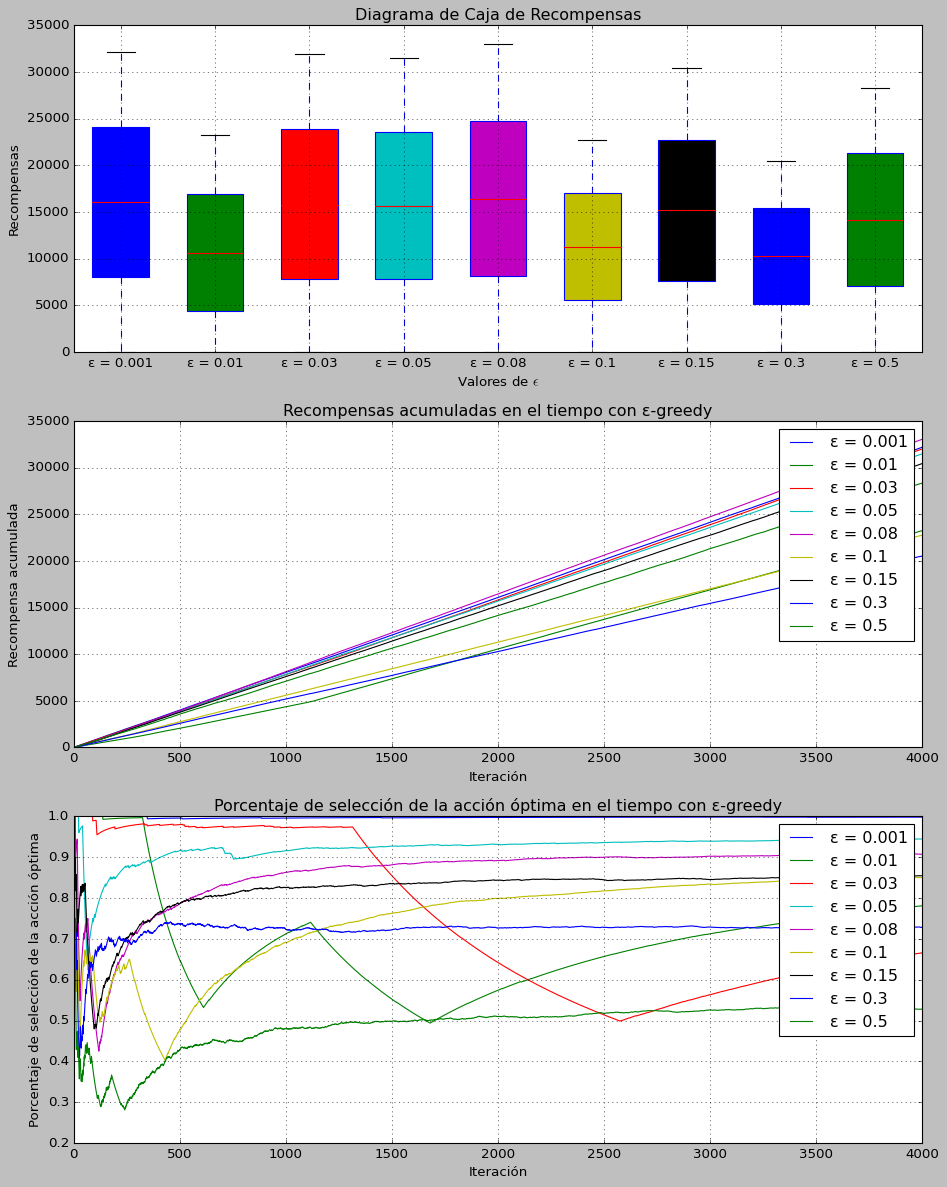

In [12]:
class BanditTestbed:
    # conditions
    np.random.seed(0)

    def __init__(self, num_bandits, mean, varianceInitBandits):
        self.bandits_mean_values = np.random.normal(mean, np.sqrt(varianceInitBandits), size=num_bandits)
        self.action_values = np.zeros(num_bandits)
        self.action_counts = np.zeros(num_bandits)
        self.total_rewards = 0
        self.q_estimated = np.zeros(num_bandits)
        self.optimal_action_count = 0
        self.rewards_history = []
        self.optimal_action_percentage_history = []
        self.bandits = num_bandits

    def pullArm(self, action, varianceActions):
        reward = np.random.normal(self.bandits_mean_values[action], varianceActions)
        # revisar en t-1
        self.q_estimated[action] = self.action_values[action] / (self.action_counts[action] + + 1e-5)
        self.action_values[action] += reward
        self.action_counts[action] += 1
        self.total_rewards += reward
        self.rewards_history.append(reward)
        if action == np.argmax(self.action_values):
            self.optimal_action_count += 1
        self.optimal_action_percentage_history.append(self.optimal_action_count / sum(self.action_counts))
        
    def greedy(self):
        action = np.argmax(self.action_values / (self.action_counts + 1e-5))
        return action

    def epsilon_greedy(self, epsilon, num_iterations, varianceActions):
        rewards = []
        for i in range(num_iterations):
            rand_num = np.random.rand()
            if rand_num < epsilon:
                action = np.random.choice(num_bandits)
            else:
                '''
                    Cabe resaltar que el valor de 1e-5 se introduce para evitar que la
                    división tienda a infinito cuando el número de acciones tomadas es 0.
                '''
                action = self.greedy() 
            self.pullArm(action, varianceActions)    
            rewards.append(self.total_rewards)
        return rewards, self.optimal_action_percentage_history


def run_experiment(num_bandits, num_iterations, epsilon_values, varianceActions, mean, varianceInitBandits):
    rewards_history = []
    optimal_action_percentage_history = []
    for epsilon in epsilon_values:
        testbed = BanditTestbed(num_bandits, mean, varianceInitBandits)
        rewards, optimal_action_percentage = testbed.epsilon_greedy(epsilon, num_iterations, varianceActions)
        rewards_history.append(rewards)
        optimal_action_percentage_history.append(optimal_action_percentage)
    return rewards_history, optimal_action_percentage_history


def plot_results(epsilon_values, rewards_history, optimal_action_percentage_history):
    plt.figure(figsize=(12, 15))
    plt.subplot(3, 1, 1)
    for i, epsilon in enumerate(epsilon_values):
        plt.boxplot(rewards_history[i], positions=[i+1], widths=0.6, patch_artist=True, boxprops=dict(facecolor=f'C{i}'))
    plt.xlabel(r'Valores de $\epsilon$')
    plt.ylabel('Recompensas')
    plt.title('Diagrama de Caja de Recompensas')
    plt.xticks(range(1, len(epsilon_values) + 1), [f'ε = {epsilon}' for epsilon in epsilon_values])
    plt.grid()
    plt.tight_layout()
    plt.subplot(3, 1, 2)
    for i, epsilon in enumerate(epsilon_values):
        plt.plot(rewards_history[i], label=f'ε = {epsilon}')
    plt.xlabel('Iteración')
    plt.ylabel('Recompensa acumulada')
    plt.title('Recompensas acumuladas en el tiempo con ε-greedy')
    plt.legend()
    plt.grid()
    plt.subplot(3, 1, 3)
    for i, epsilon in enumerate(epsilon_values):
        plt.plot(optimal_action_percentage_history[i], label=f'ε = {epsilon}')
    plt.xlabel('Iteración')
    plt.ylabel('Porcentaje de selección de la acción óptima')
    plt.title('Porcentaje de selección de la acción óptima en el tiempo con ε-greedy')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

num_bandits = 12
mean = 5
varianceInitBandits = 3
varianceActions = 1
num_iterations = 4000
epsilon_values = [0.001, 0.01, 0.03, 0.05, 0.08, 0.1, 0.15, 0.3, 0.5]

rewards_history, optimal_action_percentage_history = run_experiment(num_bandits, num_iterations, epsilon_values, varianceActions, mean, varianceInitBandits)
plot_results(epsilon_values, rewards_history, optimal_action_percentage_history)

- Punto 2

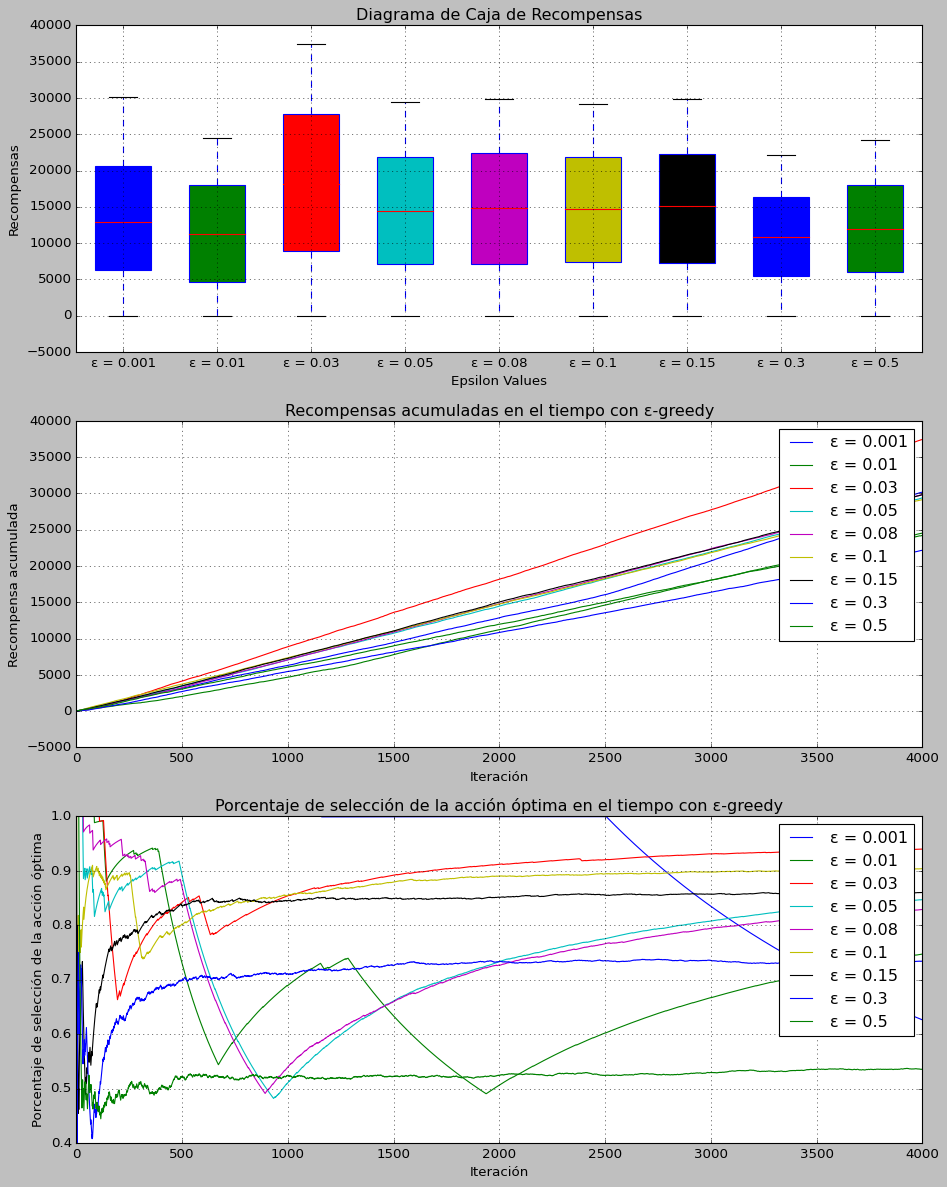

In [8]:
num_bandits = 12
mean = 5
varianceInitBandits = 3
varianceActions = 4
num_iterations = 4000
epsilon_values = [0.001, 0.01, 0.03, 0.05, 0.08, 0.1, 0.15, 0.3, 0.5]

rewards_history, optimal_action_percentage_history = run_experiment(num_bandits, num_iterations, epsilon_values, varianceActions, mean, varianceInitBandits)
plot_results(epsilon_values, rewards_history, optimal_action_percentage_history)

- Punto 3

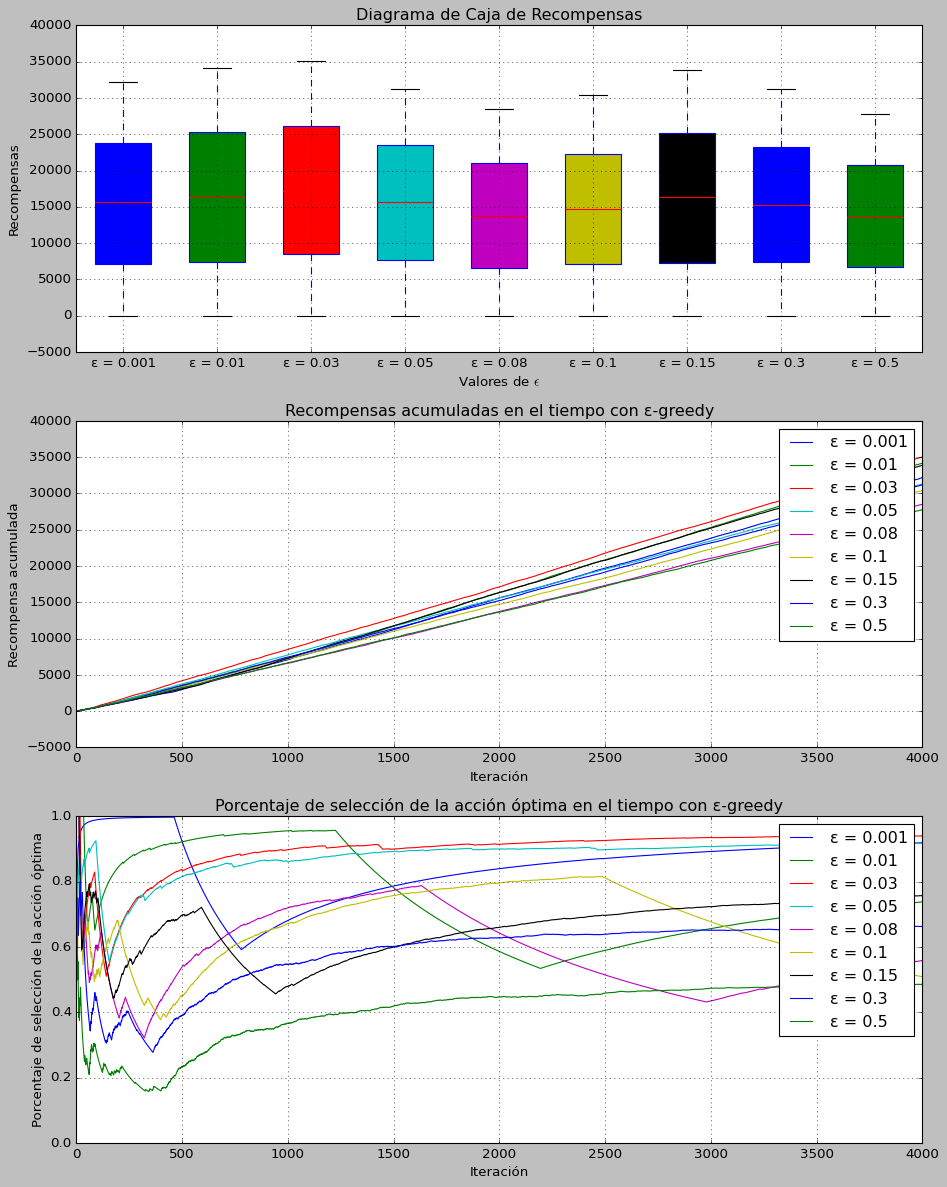

In [13]:
num_bandits = 50
mean = 5
varianceInitBandits = 3
varianceActions = 4
num_iterations = 4000
epsilon_values = [0.001, 0.01, 0.03, 0.05, 0.08, 0.1, 0.15, 0.3, 0.5]

rewards_history, optimal_action_percentage_history = run_experiment(num_bandits, num_iterations, epsilon_values, varianceActions, mean, varianceInitBandits)
plot_results(epsilon_values, rewards_history, optimal_action_percentage_history)

- Punto 4 

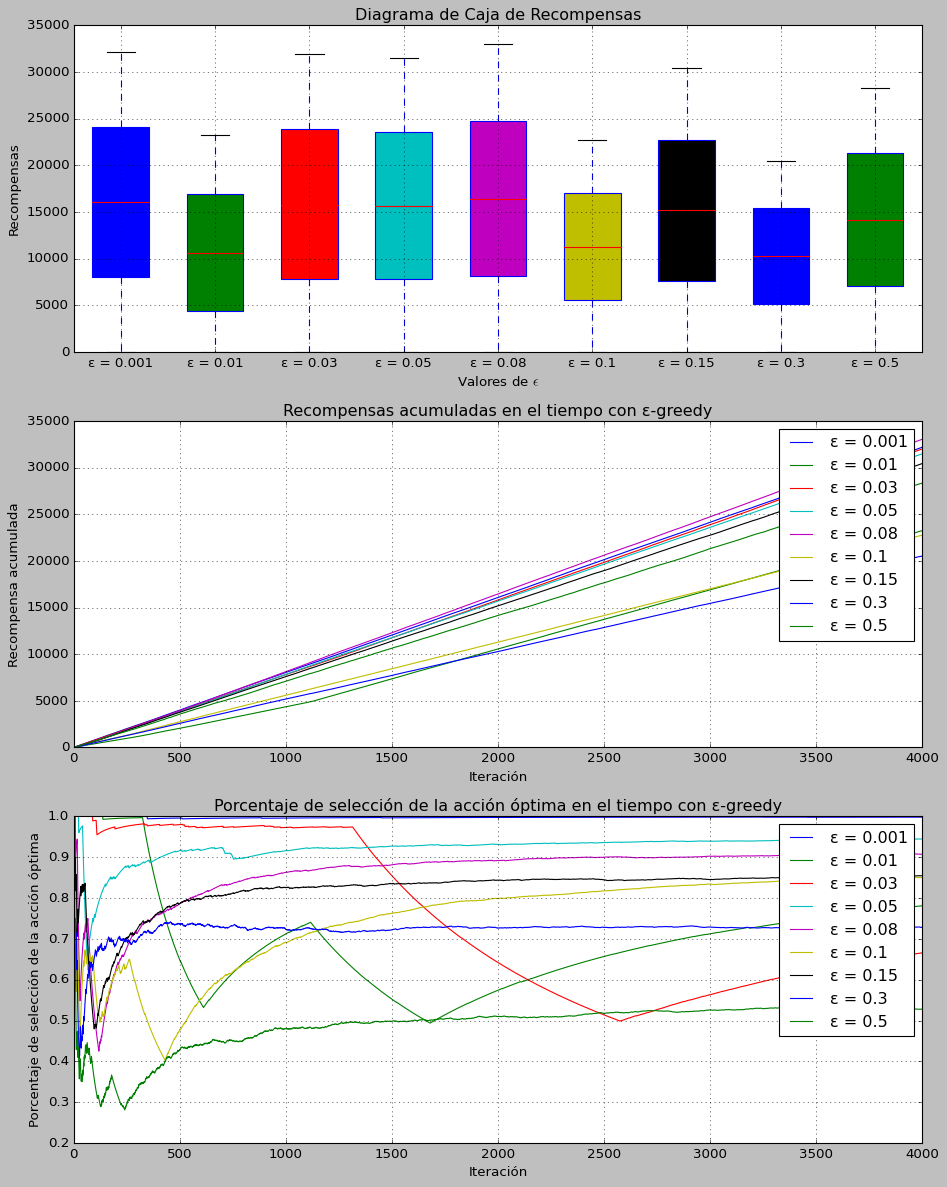

In [14]:
class BanditTestbed_change:
    # conditions
    np.random.seed(0)

    def __init__(self, num_bandits, mean, varianceInitBandits):
        self.bandits_mean_values = np.random.normal(mean, np.sqrt(varianceInitBandits), size=num_bandits)
        self.action_values = np.zeros(num_bandits)
        self.action_counts = np.zeros(num_bandits)
        self.total_rewards = 0
        self.q_estimated = np.zeros(num_bandits)
        self.optimal_action_count = 0
        self.rewards_history = []
        self.optimal_action_percentage_history = []
        self.bandits = num_bandits

    def pullArm(self, action, varianceActions):
        reward = np.random.normal(self.bandits_mean_values[action], varianceActions)
        # revisar en t-1
        # self.q_estimated[action] = self.action_values[action] / (self.action_counts[action] + + 1e-5)
        self.action_values[action] += reward
        self.action_counts[action] += 1
        self.total_rewards += reward
        self.rewards_history.append(reward)
        if action == np.argmax(self.action_values):
            self.optimal_action_count += 1
        self.optimal_action_percentage_history.append(self.optimal_action_count / sum(self.action_counts))
        
    def greedy(self, time_t):
        self.q_estimated = (self.action_values / (self.action_counts + 1e-5)) + np.cos((np.pi/120) * (time_t -20))
        action = np.argmax(self.q_estimated)
        return action

    def epsilon_greedy(self, epsilon, num_iterations, varianceActions):
        rewards = []
        for i in range(num_iterations):
            rand_num = np.random.rand()
            if rand_num < epsilon:
                action = np.random.choice(num_bandits)
            else:
                action = self.greedy(i) # Cabe resaltar que el valor de 1e-5 se introduce para evitar que la
            self.pullArm(action, varianceActions)                                # división tienda a infinito cuando el número de acciones tomadas es 0.
            rewards.append(self.total_rewards)
        return rewards, self.optimal_action_percentage_history


def run_experiment_2(num_bandits, num_iterations, epsilon_values, varianceActions, mean, varianceInitBandits):
    rewards_history = []
    optimal_action_percentage_history = []
    for epsilon in epsilon_values:
        testbed = BanditTestbed_change(num_bandits, mean, varianceInitBandits)
        rewards, optimal_action_percentage = testbed.epsilon_greedy(epsilon, num_iterations, varianceActions)
        rewards_history.append(rewards)
        optimal_action_percentage_history.append(optimal_action_percentage)
    return rewards_history, optimal_action_percentage_history

num_bandits = 12
mean = 5
varianceInitBandits = 3
varianceActions = 1
num_iterations = 4000
epsilon_values = [0.001, 0.01, 0.03, 0.05, 0.08, 0.1, 0.15, 0.3, 0.5]

rewards_history, optimal_action_percentage_history = run_experiment_2(num_bandits, num_iterations, epsilon_values, varianceActions, mean, varianceInitBandits)
plot_results(epsilon_values, rewards_history, optimal_action_percentage_history)